# Sleep Regularity Measurement
Sleep regularity is a gauge of how consistent a person’s sleep patterns are, based on the day-to-day variability in their sleep–wake times. There are at least five different metrics that can be used to quantify sleep regularity, each capturing different aspects of it and useful in its own way. The five measures of sleep regularity that we’ll look at in this blog post are listed below:

Traditional/Overall Metrics:
- Individual Standard Deviation (StDev)
- Interdaily Stability (IS)
- Social Jet Lag (SJL)

Newer Metrics:
- Composite Phase Deviation (CPD)
- Sleep Regularity Index (SRI)

All the above metrics can be transferable to behaviors beyond sleep, e.g., exercise and steps. In this work, we look into regularity in all three behaviors.

## IMPORTING LIBRARIES & DEFINING FUNCTIONS

In [21]:
import datetime as dt
import json
import warnings

import pyActigraphy
import os

import numpy as np
import pandas as pd
from dataprep.eda import create_report
from scipy import stats
from tqdm import tqdm

from notebooks_feature_engineering.feature_engineering_functions import interdaily_stability, intradaily_variability, social_jet_lag
from notebooks_preprocessing_and_dataframe_creation.preprocessing_functions import fitbit_intraday_sleep
pd.set_option('display.max_rows', 100)

In [22]:
# IMPORTANT: Function is buggy and should not be used as is; kept for archiving purposes
def fillna_sleep(df_user):
        # fill days without any sleep time
    df_user.loc[:, 'startHour'] = df_user.startTime.dt.hour
    df_user.loc[:, 'endHour'] = df_user.endTime.dt.hour
    mode_sleep_time = stats.mode(df_user.startHour, keepdims=True).mode[0]
    mode_awake_time = stats.mode(df_user.endHour, keepdims=True).mode[0]
    # convert type
    # todo
    # df_user.startHour = df_user.startHour.astype('Int64')
    # df_user.endHour = df_user.endHour.astype('Int64')
    # now fill na
    df_user.startHour.fillna(mode_sleep_time, inplace=True)
    df_user.endHour.fillna(mode_awake_time, inplace=True)
    if (mode_sleep_time >= 0) and (mode_sleep_time <= 4):
        warnings.warn("WARNING: User with most common sleep time after midnight -> Date conversion will be incorrect")

    # convert to datetime
    df_user.loc[:, "startTime"] = df_user.apply(lambda row: dt.datetime.combine(row.date, dt.time(int(row.startHour))) if pd.isna(row.startTime) else row.startTime, axis=1)
    df_user.loc[:, "endTime"] = df_user.apply(lambda row: dt.datetime.combine(row.date + dt.timedelta(days=1), dt.time(int(row.endHour))) if pd.isna(row.endTime) else row.endTime, axis=1)

    return df_user

def get_sleep_hours(df_user):
    hours_asleep = df_user.time_range
    hours_asleep.dropna(inplace=True)
    timestamps = []
    timestamps.extend(hours_asleep.apply(lambda time_range: [str(x) for x in time_range]))  # create a list of sleep hours
    timestamps = [item for sublist in timestamps for item in sublist]  # flatten list of lists into normal list
    timestamps = pd.Series(pd.to_datetime(timestamps, infer_datetime_format=True))
    return timestamps

## PREPARE DATA

In [23]:
# Read the daily unified dataframe
df = pd.read_pickle('.\\..\\data\\unified_dataframe\\data_preprocessed.pkl')
df_sleep = df[["id", "date", "nightly_temperature", "full_sleep_breathing_rate", "sleep_duration", "minutesToFallAsleep",
                           "minutesAsleep", "minutesAwake", "minutesAfterWakeup", "sleep_efficiency",
                           "sleep_deep_ratio", "sleep_wake_ratio", "sleep_light_ratio", "sleep_rem_ratio", "startTime", "endTime"]]

df_sleep.drop_duplicates(subset=['id', 'date'], inplace=True, keep="last")
df_sleep.shape

C:\Users\Sofia\AppData\Local\Temp\ipykernel_11700\3381650747.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sleep.drop_duplicates(subset=['id', 'date'], inplace=True, keep="last")


(4907, 16)

In [24]:
# Calculate sleep time ranges per day -> the results of the regularity indexes will be then be integrated with the original dataframe
df_intraday = df_sleep[['id', 'date', 'startTime', 'endTime']]
df_intraday.date = pd.to_datetime(df_intraday.date)
df_intraday.startTime = pd.to_datetime(df_intraday.startTime)
df_intraday.endTime = pd.to_datetime(df_intraday.endTime)
df_intraday.drop_duplicates(subset=['date', 'id'], keep='last', inplace=True)
# round times for easier handling
df_intraday['startTime'] = df_intraday['startTime'].dt.round('H')
df_intraday['endTime'] = df_intraday['endTime'].dt.round('H')
# extract time range column
df_intraday.loc[:, "time_range"] = df_intraday.apply(lambda row: np.nan if pd.isna(row.startTime) else pd.date_range(row.startTime, row.endTime, freq='H'), axis=1)
df_intraday.loc[:, "wear_night"] = df_intraday.apply(lambda row: 0 if pd.isna(row.startTime) else 1, axis=1)
df_intraday.head()

C:\Users\Sofia\AppData\Local\Temp\ipykernel_11700\2545844717.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intraday.date = pd.to_datetime(df_intraday.date)
C:\Users\Sofia\AppData\Local\Temp\ipykernel_11700\2545844717.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intraday.startTime = pd.to_datetime(df_intraday.startTime)
C:\Users\Sofia\AppData\Local\Temp\ipykernel_11700\2545844717.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

,id,date,startTime,endTime,time_range,wear_night
0,621e2e8e67b776a24055b564,2021-05-24,2021-05-24 01:00:00,2021-05-24 09:00:00,"DatetimeIndex(['2021-05-24 01:00:00', '2021-05...",1
1,621e328667b776a240281372,2021-05-24,NaT,NaT,NaN,0
2,621e326767b776a24012e179,2021-05-24,NaT,NaT,NaN,0
3,621e332267b776a24092a584,2021-05-24,NaT,NaT,NaN,0
4,621e333567b776a240a0c217,2021-05-24,NaT,NaT,NaN,0


### Sleep Data
Create a dataframe including sleep-awake state per hour per user

In [25]:
# create the sleep/awake dataframe per user
user_ids = set(df_intraday.id)
df_users_sleep = pd.DataFrame()
for user in tqdm(user_ids):
    # select user's data
    df_user = df_intraday.loc[df_intraday.id == user]
    # fillna for days without sleep data - BUGGY
    # df_user = fillna_sleep(df_user)
    # extract time range column
    df_user.loc[:, "time_range"] = df_user.apply(lambda row: np.nan if pd.isna(row.startTime) else pd.date_range(row.startTime, row.endTime, freq='H'), axis=1)
    # extract the asleep hours per day in a list format
    timestamps = get_sleep_hours(df_user)
    # resample the user's dataframe
    df_user = df_user.set_index('date').resample('1H').asfreq().reset_index(drop=False)
    # add new column for sleep/awake state
    df_user.loc[:, 'sleep'] = df_user.date.apply(lambda d: 1 if d in timestamps.values else 0)
    # add user id
    df_user.id = user
    # we need to drop no wear nights
    df_user.wear_night.fillna(method='ffill', inplace=True)
    df_user.wear_night = df_user.apply(lambda row: 1 if row.sleep == 1 else row.wear_night, axis=1)
    df_user = df_user.loc[df_user.wear_night == 1, :]
    # drop unnecessary columns
    df_user.drop(['startTime', 'endTime', 'time_range', 'wear_night'], inplace=True, axis=1)
    # append to common dataframe for all users
    df_users_sleep = df_users_sleep.append(df_user, ignore_index=True)
# set index to date column
df_users_sleep = df_users_sleep.set_index('date')

  0%|          | 0/71 [00:00<?, ?it/s]C:\Users\Sofia\AppData\Local\Temp\ipykernel_11700\3917996109.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user.loc[:, "time_range"] = df_user.apply(lambda row: np.nan if pd.isna(row.startTime) else pd.date_range(row.startTime, row.endTime, freq='H'), axis=1)
C:\Users\Sofia\AppData\Local\Temp\ipykernel_11700\1325524742.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hours_asleep.dropna(inplace=True)
C:\Users\Sofia\AppData\Local\Temp\ipykernel_11700\3917996109.py:26: FutureWarning: The frame.append method is dep

In [26]:
df_users_sleep.head(1000)

,id,sleep
date,,
2021-05-24 00:00:00,621e2fce67b776a240279baa,0
2021-05-24 01:00:00,621e2fce67b776a240279baa,0
2021-05-24 02:00:00,621e2fce67b776a240279baa,1
2021-05-24 03:00:00,621e2fce67b776a240279baa,1
2021-05-24 04:00:00,621e2fce67b776a240279baa,1
...,...,...
2021-07-04 11:00:00,621e2fce67b776a240279baa,0
2021-07-04 12:00:00,621e2fce67b776a240279baa,0
2021-07-04 13:00:00,621e2fce67b776a240279baa,0


# SLEEP REGULARIT MEASUREMENT

## Testing Setup

In [27]:
fpath = os.path.join(os.path.dirname(pyActigraphy.__file__),'tests/data/')
raw = pyActigraphy.io.read_raw_awd(fpath+'example_01.AWD')
acti = raw.data
acti = acti.resample('1H').sum()

## Individual Standard Deviation (StDev)
We are not working on this feature here, as it is a pure statistical feature, also available in tsfresh

## Interdaily Stability (IS) and Interdaily Variability (IV)


In [28]:
print("TESTING --- Library result: {} - Re-implementation result: {}".format(raw.IS(binarize=False), interdaily_stability(acti, column_name='0')))

TESTING --- Library result: 0.470359109153365 - Re-implementation result: 0.470359109153365


In [29]:
print("TESTING --- Library result: {} - Re-implementation result: {}".format(raw.IV(binarize=False), intradaily_variability(acti, column_name='0')))

TESTING --- Library result: 0.707705747927084 - Re-implementation result: 0.707705747927084


In [30]:
IS_index = df_users_sleep.groupby(['id']).apply(lambda data: interdaily_stability(data, column_name="sleep"))
IS_index.head(10)

C:\Users\Sofia\PycharmProjects\RAIS-miniproject\notebooks_feature_engineering\feature_engineering_functions.py:130: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d_24h = data.groupby([
C:\Users\Sofia\PycharmProjects\RAIS-miniproject\notebooks_feature_engineering\feature_engineering_functions.py:136: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  d_1h = data.var()
C:\Users\Sofia\PycharmProjects\RAIS-miniproject\notebooks_feature_engineering\feature_engineering_functions.py:130: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a f

,sleep
id,
621e2e8e67b776a24055b564,0.930443
621e2eaf67b776a2406b14ac,0.739059
621e2ed667b776a24085d8d1,0.803678
621e2efa67b776a2409dd1c3,0.755434
621e2f1b67b776a240b3d87c,0.724169
621e2f3967b776a240c654db,0.641647
621e2f5767b776a240d8f9d6,0.654102
621e2f6167b776a240e082a9,0.790809
621e2f7a67b776a240f14425,0.859299


In [31]:
IV_index = df_users_sleep.groupby(['id']).apply(lambda data: intradaily_variability(data, column_name="sleep"))
IV_index.head(10)

,sleep
id,
621e2e8e67b776a24055b564,0.343581
621e2eaf67b776a2406b14ac,0.355797
621e2ed667b776a24085d8d1,0.353917
621e2efa67b776a2409dd1c3,0.354280
621e2f1b67b776a240b3d87c,0.344659
621e2f3967b776a240c654db,0.342216
621e2f5767b776a240d8f9d6,0.362598
621e2f6167b776a240e082a9,0.378257
621e2f7a67b776a240f14425,0.362621


In [32]:
OUTPUT_DIR = '.\\..\\data\\user_level_data'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
IS_index.to_pickle(os.path.join(OUTPUT_DIR, 'is_index.pkl'))
IV_index.to_pickle(os.path.join(OUTPUT_DIR, 'iv_index.pkl'))

## Social Jet Lag (SJL)

In [33]:
df_sleep.head()

,id,date,nightly_temperature,full_sleep_breathing_rate,sleep_duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio,startTime,endTime
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,14.8,31260000.0,0.0,445.0,76.0,0.0,93.0,1.243243,0.987013,0.921642,1.341772,2021-05-24T00:40:00.000,2021-05-24T09:21:00.000
1,621e328667b776a240281372,2021-05-24,33.973120,14.6,27240000.0,0.0,399.0,54.0,0.0,95.0,0.986206,0.963636,0.984866,0.987500,NaN,NaN
2,621e326767b776a24012e179,2021-05-24,33.973120,14.4,27240000.0,0.0,399.0,54.0,0.0,95.0,0.986206,0.963636,0.984866,0.987500,NaN,NaN
3,621e332267b776a24092a584,2021-05-24,33.973120,14.6,27240000.0,0.0,399.0,54.0,0.0,95.0,0.986206,0.963636,0.984866,0.987500,NaN,NaN
4,621e333567b776a240a0c217,2021-05-24,33.973120,14.6,27240000.0,0.0,399.0,54.0,0.0,95.0,0.986206,0.963636,0.984866,0.987500,NaN,NaN


<AxesSubplot: >

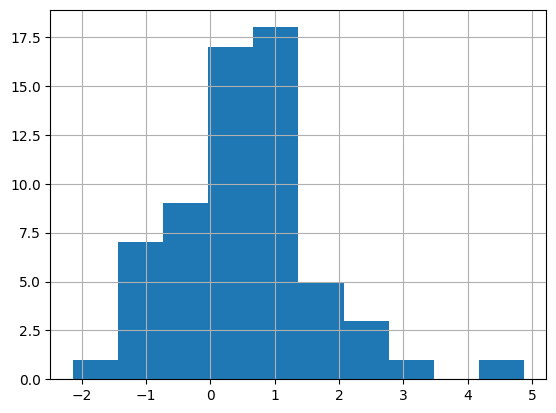

In [34]:
sjl = df_sleep.groupby('id').apply(lambda user_data: social_jet_lag(user_data))
sjl.hist()

## Composite Phase Deviation (CPD)

## Sleep Regularity Index (SRI)